(Additional study)

This notebook aims at discovering the job postings dataset

Dataset source: https://www.kaggle.com/datasets/asaniczka/data-science-job-postings-and-skills/data?select=job_postings.csv

# Import libraries

In [23]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load data

In [24]:
df = pd.read_csv('/content/drive/MyDrive/UNIPI AIDE/1° anno/Data mining & ML/Project/Job Recommender/job_postings.csv')
df_skills = pd.read_csv('/content/drive/MyDrive/UNIPI AIDE/1° anno/Data mining & ML/Project/Job Recommender/job_skills.csv')
df_summary = pd.read_csv('/content/drive/MyDrive/UNIPI AIDE/1° anno/Data mining & ML/Project/Job Recommender/job_summary.csv')
# qui ho anche: job_type, job_level, company
#df_summary è tutta la job description e ad alcuni c'è il salary range in $

# Data Preprocessing

In [25]:
# merge to get a single df for the job postings
df = pd.merge(df, df_skills, on='job_link')
df = pd.merge(df, df_summary, on = 'job_link')

In [26]:
# check total null values per column
print('---Total null values per column---\n', df.isnull().sum())
# drop useless columns for my purpose
df = df.drop(columns = ['job_link', 'search_city', 'last_processed_time',	'last_status',	'got_summary',	'got_ner',	'is_being_worked', 'first_seen', ]).reset_index()
df = df.rename(columns = {'index': 'jobID', 'job_title': 'position', 'job_location': 'city', 'search_country': 'country', 'search_position': 'category', 'job_skills': 'skills', 'job_summary': 'description'})


# Remove useless characters on the skills column
df['skills'] = df['skills'].str.replace(r'\[|\]|\'', '', regex=True)
#df['skills'] = df['skills'].apply(lambda x: re.sub(r'[^\x00-\x7f]', r'', x))
# check null values
print('--- 1- [Are there NaN values?]---\n', df.isnull().values.any())
df = df.dropna(how='all', axis=1)     # drop column if there are all null values
df = df.dropna(how='any', axis=0)     # drop row if there is at least one null value (drop 25 rows that have null value in Experience)
df = df.loc[:, df.nunique() > 1]
print('--- 2- [Are there NaN values?]---\n', df.isnull().values.any())      # re-check null values
df['desc_length'] = df['description'].apply(lambda x: len(str(x).split()))     # can be useful analyze the length
df['pos_length'] = df['position'].apply(lambda x: len(str(x).split()))     # can be useful analyze the length
print('---Total null values per column---\n', df.isnull().sum())

---Total null values per column---
 job_link               0
last_processed_time    0
last_status            0
got_summary            0
got_ner                0
is_being_worked        0
job_title              0
company                0
job_location           1
first_seen             0
search_city            0
search_country         0
search_position        0
job_level              0
job_type               0
job_skills             5
job_summary            0
dtype: int64
--- 1- [Are there NaN values?]---
 True
--- 2- [Are there NaN values?]---
 False
---Total null values per column---
 jobID          0
position       0
company        0
city           0
country        0
category       0
job_level      0
job_type       0
skills         0
description    0
desc_length    0
pos_length     0
dtype: int64


In [27]:
# df = df.drop(columns = ['description'])

In [28]:
# Drop duplicates
df = df.drop_duplicates()

In [29]:
df

,jobID,position,company,city,country,category,job_level,job_type,skills,description,desc_length,pos_length
0,0,Senior Machine Learning Engineer,Jobs for Humanity,"New Haven, CT",United States,Agricultural-Research Engineer,Mid senior,Onsite,"Machine Learning, Programming, Python, Scala, ...",Company Description\nJobs for Humanity is part...,1105,4
1,1,"Principal Software Engineer, ML Accelerators",Aurora,"San Francisco, CA",United States,Set-Key Driver,Mid senior,Onsite,"C++, Python, PyTorch, TensorFlow, MXNet, CUDA,...",Who We Are\nAurora (Nasdaq: AUR) is delivering...,1037,5
2,2,Senior ETL Data Warehouse Specialist,Adame Services LLC,"New York, NY",United States,Technical Support Specialist,Associate,Onsite,"ETL, Data Integration, Data Transformation, Da...","Location: New York City, NY\nPosition Summary\...",329,5
3,3,Senior Data Warehouse Developer / Architect,Morph Enterprise,"Harrisburg, PA",United States,Architect,Mid senior,Onsite,"Data Lakes, Data Bricks, Azure Data Factory Pi...",Responsibilities:\nCandidate must have signifi...,200,6
4,4,Lead Data Engineer,Dice,"Plano, TX",United States,Maintenance Data Analyst,Mid senior,Onsite,"Java, Scala, Python, RDBMS, NoSQL, Redshift, S...",Dice is the leading career destination for tec...,835,3
...,...,...,...,...,...,...,...,...,...,...,...,...
12212,12212,"Data Reporting Manager, FOOTBALL ASSOCIATION",Guardian Jobs,"Wembley, England, United Kingdom",United Kingdom,Manager Forms Analysis,Mid senior,Onsite,"Dashboard development, Reporting, Power BI, SQ...","FOOTBALL ASSOCIATION\nMake an impact, on and o...",1037,5
12213,12213,Corporate AML Alert Investigation Specialist,"Glacier Bancorp, Inc.","Kalispell, MT",United States,Teller,Mid senior,Onsite,"Investigation, Antimoney laundering, Fraud, Ba...",About The Role\nPlease note: review of applica...,1321,5
12214,12214,Senior Data Scientist,Highnote,"San Francisco, CA",United States,Mathematician,Mid senior,Onsite,"Data Science, Quantitative Modeling, SQL, Data...",About Highnote\nFounded in 2020 by a team of l...,741,3
12215,12215,Senior Data Engineer,CompSource Mutual Insurance Company,"Oklahoma City, OK",United States,Protection Engineer,Mid senior,Onsite,"Data Engineering, Data Quality, SQL, Python, T...",Are you an experienced data engineer in Oklaho...,331,3


## Save df for the job recommender

In [30]:
df.to_csv('/content/drive/MyDrive/UNIPI AIDE/1° anno/Data mining & ML/Project/Job Recommender/job_cleaned.csv', index = False)

# Job similarity

In [31]:
#df = df.reset_index().rename(columns = {'index': 'jobID'})   (already done in preprocessing)

I use 'category', 'position', 'company', 'description', 'city', 'country', 'skills'. I convert text into its numeric representation using CountVectorizer or TfidfVectorizer. I build a df where each row is a job vector of the score similarity (0-1) of it compared to each other job offer.

In [32]:
# Specify the names of the columns you want to merge
columns_to_merge = ['category', 'position', 'company', 'description', 'city', 'country', 'skills'] #['category', 'experience', 'position', 'city', 'country', 'skills']

df['data'] = df[columns_to_merge].apply(lambda x: ' '.join(x.astype(str)), axis=1)

In [33]:
def calculate_similarity(df):
    # Using TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_vectorized = tfidf_vectorizer.fit_transform(df['data'])
    tfidf_similarities = cosine_similarity(tfidf_vectorized)
    # Build a job-job df
    df_tfidf_job = pd.DataFrame(tfidf_similarities, columns=df['jobID'], index=df['jobID']).reindex()

    # Using CountVectorizer
    count_vectorizer = CountVectorizer(stop_words='english')
    count_vectorized = count_vectorizer.fit_transform(df['data'])
    count_similarities = cosine_similarity(count_vectorized)
    # Build a job-job df
    df_count_job = pd.DataFrame(count_similarities, columns=df['jobID'], index=df['jobID']).reindex()

    return df_tfidf_job, df_count_job

def extract_recommendations(df_tfidf_job, df_count_job, input_job):
    # Extracting recommendations using TF-IDF
    tfidf_recommendations = pd.DataFrame(df_tfidf_job.nlargest(11, input_job)).iloc[1:].index

    # Extracting recommendations using CountVectorizer
    count_recommendations = pd.DataFrame(df_count_job.nlargest(11, input_job)).iloc[1:].index

    return tfidf_recommendations, count_recommendations

In [34]:
# Calculate similariy
df_tfidf_job, df_count_job = calculate_similarity(df)

In [35]:
# Extract recommendations (change input_job)
tfidf_recommendations, count_recommendations = extract_recommendations(df_tfidf_job, df_count_job, input_job=35)

print("TF-IDF Recommendations:")
print(tfidf_recommendations)
print("\nCountVectorizer Recommendations:")
print(count_recommendations)

TF-IDF Recommendations:
Index([1998, 7116, 2739, 8067, 10390, 497, 1121, 4345, 2197, 11651], dtype='int64', name='jobID')

CountVectorizer Recommendations:
Index([11651, 1998, 1121, 2491, 8213, 810, 7827, 9733, 7611, 8772], dtype='int64', name='jobID')


do it for all the input_jobs and check the n of equal jobs each time and compute the rate, for comparison purposes.

# EDA

In [36]:
df

,jobID,position,company,city,country,category,job_level,job_type,skills,description,desc_length,pos_length,data
0,0,Senior Machine Learning Engineer,Jobs for Humanity,"New Haven, CT",United States,Agricultural-Research Engineer,Mid senior,Onsite,"Machine Learning, Programming, Python, Scala, ...",Company Description\nJobs for Humanity is part...,1105,4,Agricultural-Research Engineer Senior Machine ...
1,1,"Principal Software Engineer, ML Accelerators",Aurora,"San Francisco, CA",United States,Set-Key Driver,Mid senior,Onsite,"C++, Python, PyTorch, TensorFlow, MXNet, CUDA,...",Who We Are\nAurora (Nasdaq: AUR) is delivering...,1037,5,"Set-Key Driver Principal Software Engineer, ML..."
2,2,Senior ETL Data Warehouse Specialist,Adame Services LLC,"New York, NY",United States,Technical Support Specialist,Associate,Onsite,"ETL, Data Integration, Data Transformation, Da...","Location: New York City, NY\nPosition Summary\...",329,5,Technical Support Specialist Senior ETL Data W...
3,3,Senior Data Warehouse Developer / Architect,Morph Enterprise,"Harrisburg, PA",United States,Architect,Mid senior,Onsite,"Data Lakes, Data Bricks, Azure Data Factory Pi...",Responsibilities:\nCandidate must have signifi...,200,6,Architect Senior Data Warehouse Developer / Ar...
4,4,Lead Data Engineer,Dice,"Plano, TX",United States,Maintenance Data Analyst,Mid senior,Onsite,"Java, Scala, Python, RDBMS, NoSQL, Redshift, S...",Dice is the leading career destination for tec...,835,3,Maintenance Data Analyst Lead Data Engineer Di...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12212,12212,"Data Reporting Manager, FOOTBALL ASSOCIATION",Guardian Jobs,"Wembley, England, United Kingdom",United Kingdom,Manager Forms Analysis,Mid senior,Onsite,"Dashboard development, Reporting, Power BI, SQ...","FOOTBALL ASSOCIATION\nMake an impact, on and o...",1037,5,"Manager Forms Analysis Data Reporting Manager,..."
12213,12213,Corporate AML Alert Investigation Specialist,"Glacier Bancorp, Inc.","Kalispell, MT",United States,Teller,Mid senior,Onsite,"Investigation, Antimoney laundering, Fraud, Ba...",About The Role\nPlease note: review of applica...,1321,5,Teller Corporate AML Alert Investigation Speci...
12214,12214,Senior Data Scientist,Highnote,"San Francisco, CA",United States,Mathematician,Mid senior,Onsite,"Data Science, Quantitative Modeling, SQL, Data...",About Highnote\nFounded in 2020 by a team of l...,741,3,Mathematician Senior Data Scientist Highnote A...
12215,12215,Senior Data Engineer,CompSource Mutual Insurance Company,"Oklahoma City, OK",United States,Protection Engineer,Mid senior,Onsite,"Data Engineering, Data Quality, SQL, Python, T...",Are you an experienced data engineer in Oklaho...,331,3,Protection Engineer Senior Data Engineer CompS...


country
United States     10286
United Kingdom      994
Canada              630
Australia           301
Name: count, dtype: int64


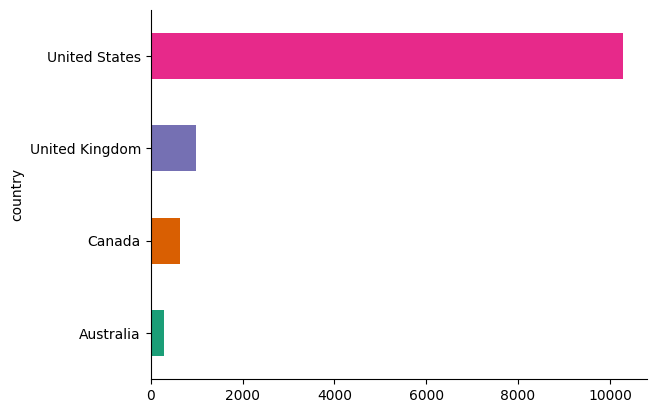

In [37]:
# @title country
print(df.country.value_counts())
df.groupby('country').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

job_level
Mid senior    10914
Associate      1297
Name: count, dtype: int64


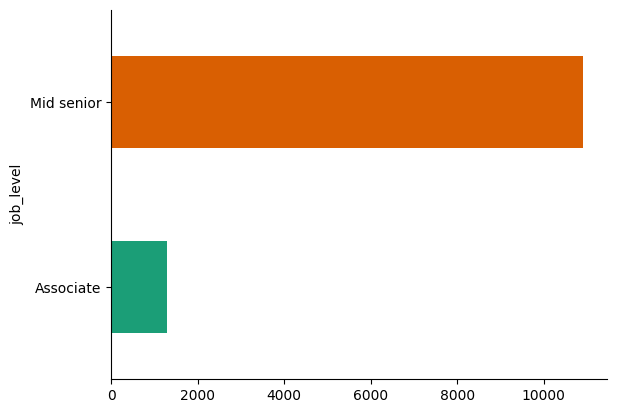

In [38]:
# @title job_level
print(df.job_level.value_counts())
df.groupby('job_level').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

job_type
Onsite    12182
Remote       18
Hybrid       11
Name: count, dtype: int64


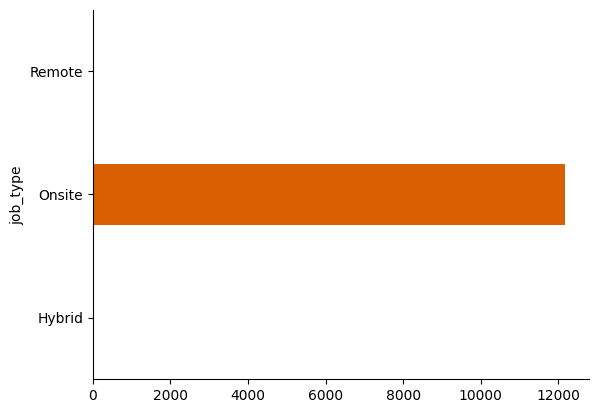

In [39]:
# @title job type
print(df.job_type.value_counts())
df.groupby('job_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

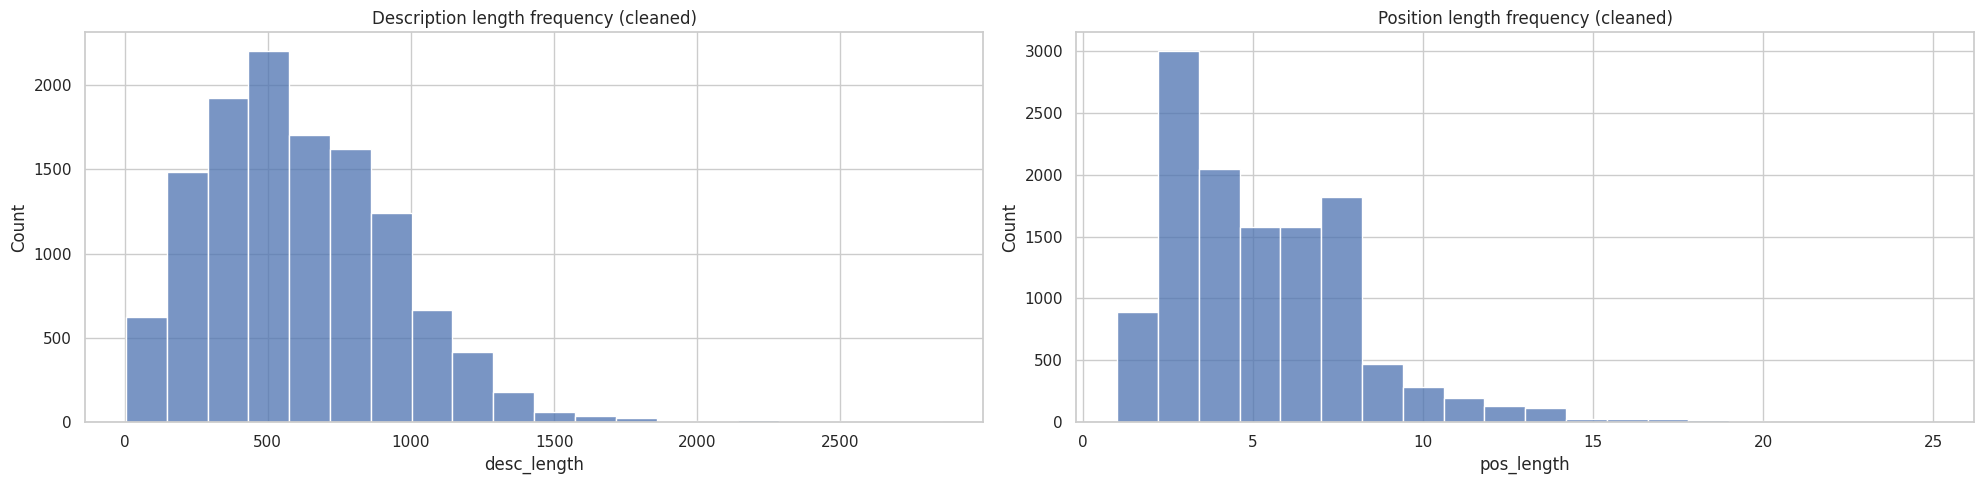

In [40]:
# Plot length frequency histograms for description, experience and position column. (before and after cleaning)
# Just remove cleaned to get the attribute columns before the cleaning step (if not already removed&renamed in the cell above)
# Set the style to whitegrid (optional)
sns.set(style="whitegrid")

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# Plot the histogram for 'exp_length'
sns.histplot(df['desc_length'], bins=20, kde=False, ax=axes[0])
axes[0].set_title('Description length frequency (cleaned)')

# Plot the histogram for 'pos_length'
sns.histplot(df['pos_length'], bins=20, kde=False, ax=axes[1])
axes[1].set_title('Position length frequency (cleaned)')

# Adjust layout
plt.tight_layout()

# Save the plots together
#plt.savefig('length_freq__cleaned_histograms.jpg')

# Show the plots
plt.show()

<ipython-input-41-40f52c086c47>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=company_counts.values, y=company_counts.index, palette = palette)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


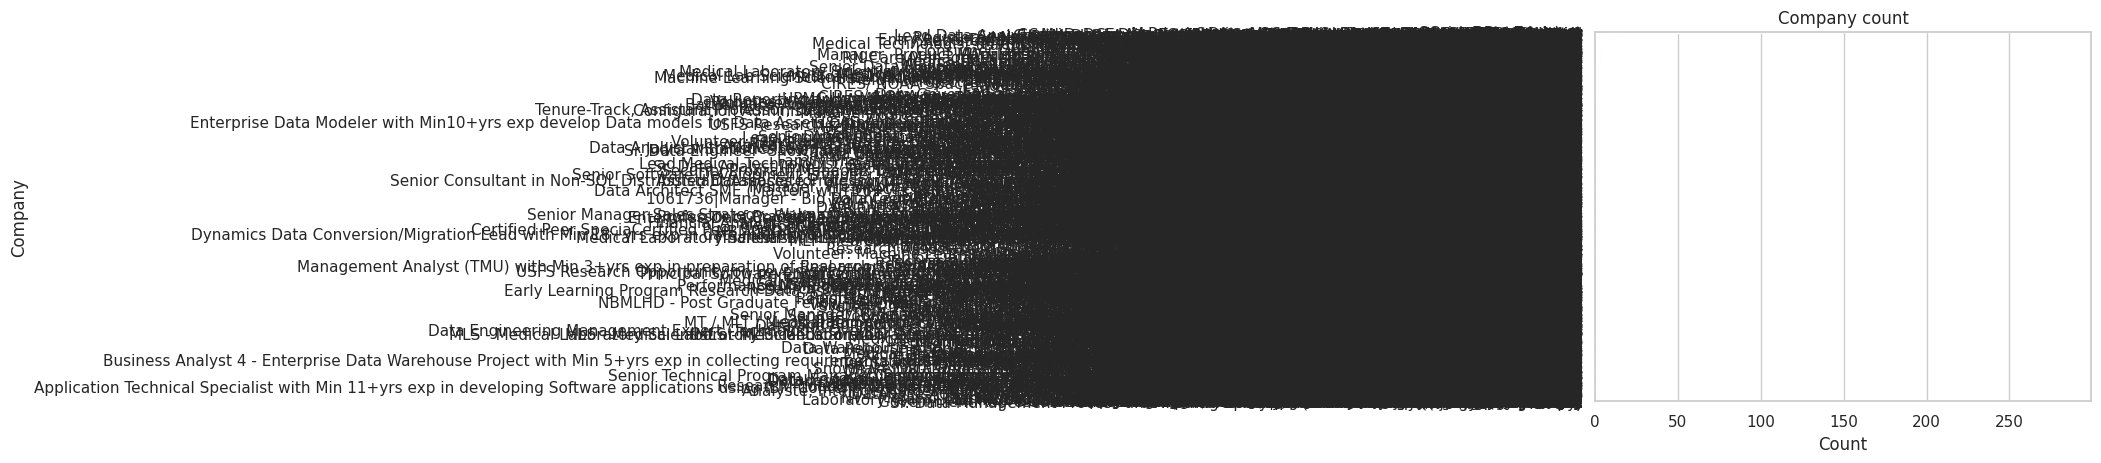

In [41]:
# Get the counts of each company
company_counts = df['position'].value_counts()

# Use a sequential color palette
palette = sns.color_palette("dark:blue_r", n_colors=len(company_counts))

# Plot the histogram using seaborn
sns.barplot(x=company_counts.values, y=company_counts.index, palette = palette)

# Labels
plt.xlabel('Count')
plt.ylabel('Company')
plt.title('Company count')

# Save plot
#plt.savefig('Company count.jpg')
plt.show()

<ipython-input-42-19f33bcdd176>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=position_counts.values, y=position_counts.index, palette = palette)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


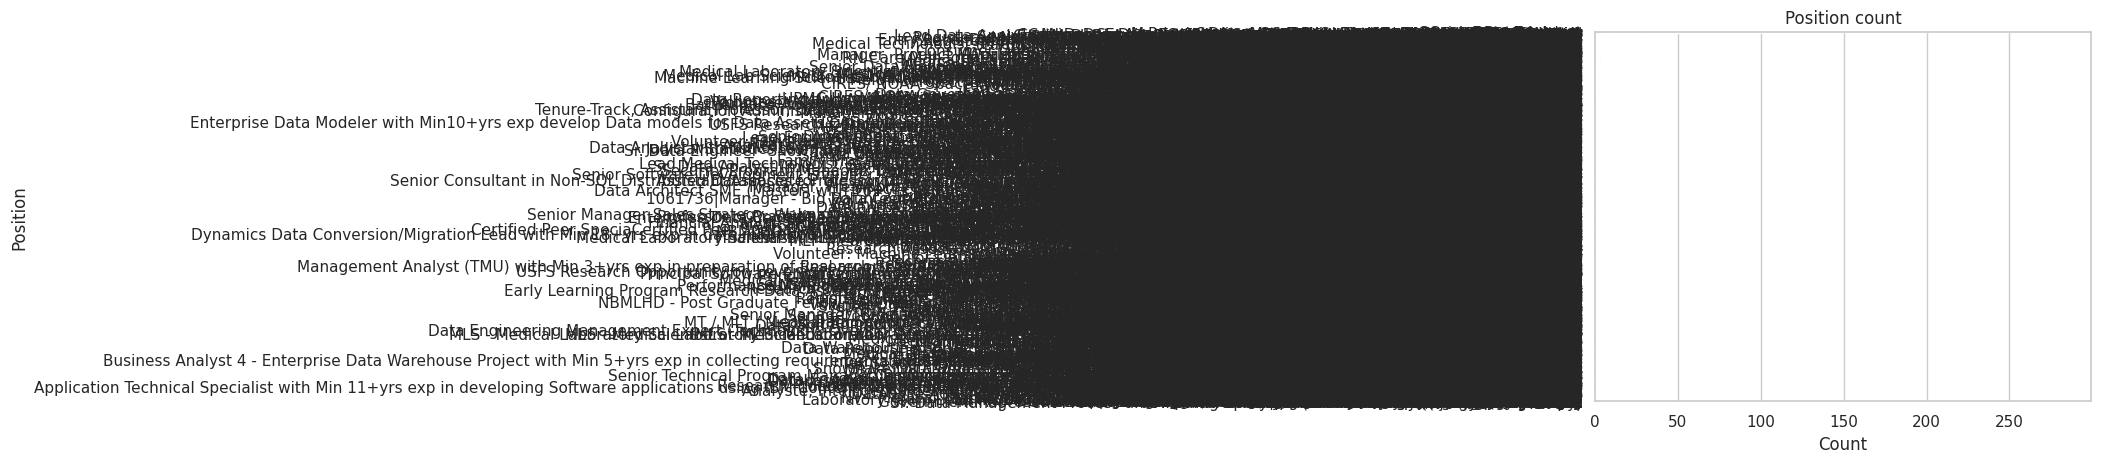

In [42]:
# Get the counts of each position
position_counts = df['position'].value_counts()

# Use a sequential color palette
palette = sns.color_palette("dark:blue_r", n_colors=len(position_counts))

# Plot the histogram using seaborn
sns.barplot(x=position_counts.values, y=position_counts.index, palette = palette)

# Labels
plt.xlabel('Count')
plt.ylabel('Position')
plt.title('Position count')

# Save plot
#plt.savefig('Position count.jpg')
plt.show()

category
Data Entry Clerk                  1088
Data Base Administrator           1016
Agricultural-Research Engineer     943
Data Communications Analyst        883
Architect                          462
                                  ... 
Supervisor Coffee                    1
Mathematical Technician              1
Loader                               1
Form Builder                         1
Tourist-Information Assistant        1
Name: count, Length: 711, dtype: int64


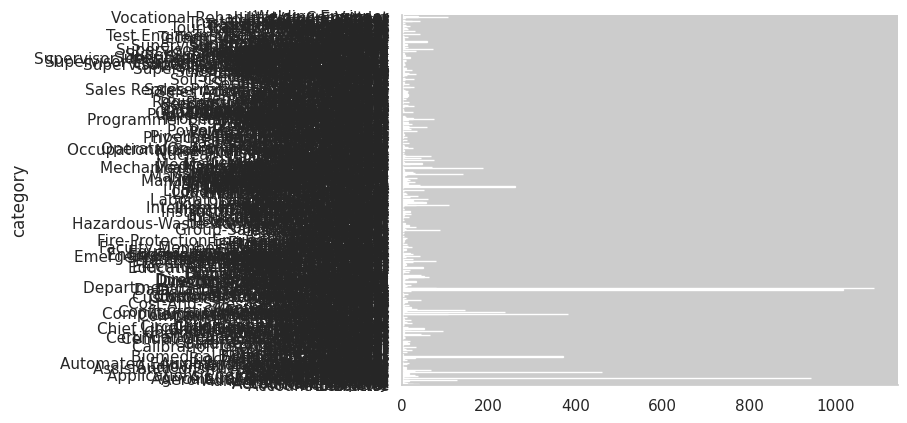

In [43]:
# @title category
print(df.category.value_counts())
df.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)